## Overview
* Country: United States, France, Germany, Japan, United Kingdom, Italy, Canada
* Time period: 1950-2018, 69 years
* Target variable: `ngdp_rpch` for annual data, `ngdp_r_sa_pcha` and `ngdp_r_sa_pchy` (respectively) for quarterly data
* Train-test split: 1950-2009 (train, ≤ x  years, depends on data availability), x - y (test, z years)   
  _Need further discussion. Here I divide the dataset by x/y just as the working paper did. Now for the ML model family we do not need to do such split._
  
* LSTM Model
* CNN Model

## Import packages

In [1]:
# Module 1: Importing the libraries

import tensorflow as tf
from tensorflow import keras
keras = tf.keras

# Print all outputs in a code block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Importing the libraries
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline


# from tf.random import set_seed

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

from keras.callbacks import ModelCheckpoint

# from keras.callbacks import ResetStatesCallback()

from keras.layers import Conv1D
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten,Dense
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [3]:
from tensorflow import random
# from tensorflow.random import set_seed

In [4]:
# Set Seed

seed_global = 42

# Source: https://machinelearningmastery.com/reproducible-results-neural-networks-keras/

from numpy.random import seed
seed(seed_global)

#  Giving an eror 
# from tensorflow import set_random_seed
# set_random_seed(seed_global)

# Source: https://stackoverflow.com/questions/58638701/importerror-cannot-import-name-set-random-seed-from-tensorflow-c-users-po

tf.random.set_seed(seed_global)

# Copy paste this code snippet in every model code chunk 
seed(seed_global)
tf.random.set_seed(seed_global)

# --Ignore--
# tf.random.set_seed(seed)
# # This is giving me an error

# #  Global Seed
# # random.seed (2019) 

## Get data

In [5]:
%%bigquery gdp_quarterly_q

SELECT *
FROM `deep-nexus.temp_for_imf_data.WEO_G7_Quarterly`
ORDER BY time

In [6]:
gdp_quarterly_q.year = (gdp_quarterly_q.time+40)//4 + 1950
gdp_quarterly_q.quarter = (gdp_quarterly_q.time+40)%4 + 1
gdp_quarterly_q.time = gdp_quarterly_q.year.astype('str') + 'Q' + gdp_quarterly_q.quarter.astype('str')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [7]:
gdp_quarterly_q = pd.DataFrame(gdp_quarterly_q)
gdp_quarterly_q.head(5)

,country,ifscode,time,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,...,pcpi_sa,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt
0,United States,111,1950Q1,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,...,NaN,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN
1,United Kingdom,112,1950Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,72.776393,NaN,72.776393,NaN,NaN,NaN,NaN
2,France,132,1950Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,47.016824,NaN,47.016824,NaN,NaN,NaN,NaN
3,Germany,134,1950Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Italy,136,1950Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Selecting a subset of countries
gdp_quarterly_q.country.unique()

selected_countries = list(gdp_quarterly_q.country.unique())[0:1]
print("\nSelected Countries: \n")
selected_countries

array(['United States', 'United Kingdom', 'France', 'Germany', 'Italy',
       'Canada', 'Japan'], dtype=object)


Selected Countries: 



['United States']

In [9]:
# dataset_2 = gdp_quarterly_q

# for i in selected_countries:
#    dataset_2[i] = gdp_quarterly_q[gdp_quarterly_q['country'] == i]

# https://stackoverflow.com/questions/51583888/concatenate-dataframe-name-with-variable-value-python

In [10]:
# # Random Forest Regressor

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error

# # random forest model creation

# # Set Seed
# seed(seed_global)
# tensorflow.random.set_seed(seed_global)


# rfr = RandomForestRegressor(n_estimators = 1000)

# rfr.fit(X_train, y_train)

# # predictions
# y_pred = rfr.predict(X_test)

# metrics_mse["random_forest"] =  mean_squared_error(y_test, y_pred)

# print("Random Forest Test MSE: ", mean_squared_error(y_test, y_pred))

In [11]:
# # Variable Importance

# # Top i factors by importance

# i = 20
# importances = rf_reg.feature_importances_
# indices = np.argsort(importances)[-(i-1):]
# features = X.columns

# plt.figure(figsize=(6,6))
# plt.title('Feature Importances - Random Forest Regressor')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), features[indices])
# plt.xlabel('Relative Importance')

In [12]:
# Filter data by country

dataset = gdp_quarterly_q[gdp_quarterly_q['country'].isin(selected_countries)]

dataset = pd.DataFrame(dataset)
# print ("#", "column name", "missing values")
# for i in range(len(dataset.columns)):
#     print(i, dataset.columns[i], " ", dataset.iloc[i].isnull().count())

dataset.head(5)

,country,ifscode,time,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,...,pcpi_sa,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt
0,United States,111,1950Q1,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,...,NaN,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN
7,United States,111,1950Q2,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,...,NaN,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN
14,United States,111,1950Q3,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,...,NaN,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN
21,United States,111,1950Q4,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,...,NaN,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN
28,United States,111,1951Q1,NaN,NaN,NaN,0.062002,NaN,NaN,NaN,...,NaN,NaN,NaN,348.993057,NaN,348.993057,8.709073,11.508033,10.159067,12.875869


## Variable selection

In [13]:
# Variable selection

# Input Columns
# Selecting 10 variables

dataset_input = dataset

dataset_input = dataset_input.drop(columns = ['country', 'ifscode', 'time', 'ngdp_r_sa_pcha', 'ngdp_r_sa_pchy', 'ngdp_dpchy'])

# Dropped ngdp_dpchy as all values are null

dataset_input.tail(5)

,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,pcpi_sa,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt
1897,18155.700000,10628.0,153.952333,0.160311,110.571,4.133333,2565.6,0.469925,12729.7,1.139334,...,247.273333,3.141889,2.109865,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625
1904,18819.741667,10786.0,154.951667,0.162071,111.839,4.066667,2578.3,0.495011,12782.9,0.417920,...,249.250333,3.236639,2.222997,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725
1911,18819.741667,10876.1,155.449000,0.162071,110.132,3.900000,2592.0,0.531358,12909.2,0.988039,...,250.578667,2.148827,2.668825,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725
1918,18819.741667,10994.3,155.879000,0.162071,110.681,3.800000,2606.0,0.540123,13019.8,0.856753,...,251.828667,2.010362,2.632912,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725
1925,18819.741667,11057.4,156.776667,0.162071,111.370,3.800000,2605.7,-0.011512,13066.3,0.357148,...,252.759000,1.485933,2.218463,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725


In [14]:
# Outcome vaiable (Column Name) = ngdp_r_sa_pcha

outcome_variable = "ngdp_r_sa_pcha"
predicted_variable = "1_step_ahead_" + outcome_variable

dataset_1 = dataset_input
dataset_1["time"] = dataset["time"]
# dataset_1[num_cols] = dataset[num_cols]
dataset_1[outcome_variable] = dataset[outcome_variable]

dataset_1[predicted_variable] = dataset_1[outcome_variable].shift(-1)

# # Source: https://stackoverflow.com/questions/20095673/shift-column-in-pandas-dataframe-up-by-one

dataset_1 = dataset_1[:-1] 

dataset_1.tail(5)

,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt,time,ngdp_r_sa_pcha,1_step_ahead_ngdp_r_sa_pcha
1890,18155.700000,10456.7,153.815333,0.160311,110.185,4.300000,2553.6,0.145104,12586.3,0.586595,...,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,2017Q3,3.202964,3.545494
1897,18155.700000,10628.0,153.952333,0.160311,110.571,4.133333,2565.6,0.469925,12729.7,1.139334,...,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,2017Q4,3.545494,2.552107
1904,18819.741667,10786.0,154.951667,0.162071,111.839,4.066667,2578.3,0.495011,12782.9,0.417920,...,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2018Q1,2.552107,3.512025
1911,18819.741667,10876.1,155.449000,0.162071,110.132,3.900000,2592.0,0.531358,12909.2,0.988039,...,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2018Q2,3.512025,2.926498
1918,18819.741667,10994.3,155.879000,0.162071,110.681,3.800000,2606.0,0.540123,13019.8,0.856753,...,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2018Q3,2.926498,1.089155


In [15]:
# Output Columns

# ngdp_r_sa_pcha: WEO: Gross domestic product, constant prices, seasonally adjusted, quarter-over-quarter percent change, annualized (Percent, Units).

dataset_Y = dataset_1[["time", predicted_variable]]
dataset_Y.tail(5)

,time,1_step_ahead_ngdp_r_sa_pcha
1890,2017Q3,3.545494
1897,2017Q4,2.552107
1904,2018Q1,3.512025
1911,2018Q2,2.926498
1918,2018Q3,1.089155


In [16]:
# Window size and crearting the lagged columns

#  Using a lag = 0 for identifying initial variable importance by fitting a randowm forest 
# window size 
lag = 1
dataset_input_l = dataset_1

# Drop the 1) preducted outcome variable and 2) time variable 

dataset_input_l = dataset_input_l.drop(columns = ["time", predicted_variable])

print("Before adding the lagged variables to the input dataset: ")
dataset_input_l.tail(5)

# Lagging each column in num_columns by the entire range of lag factors

for j in dataset_input_l.columns:
    for i in range(1, (lag + 1), 1):
        new_col = str(j)+"-"+str(i)
        dataset_input_l[str(new_col)] = dataset_input_l[str(j)].shift(i)
    
print("After adding the lagged variables to the input dataset: ")
dataset_input_l.tail(5)

Before adding the lagged variables to the input dataset: 


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt,ngdp_r_sa_pcha
1890,18155.700000,10456.7,153.815333,0.160311,110.185,4.300000,2553.6,0.145104,12586.3,0.586595,...,2.153214,1.981427,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,3.202964
1897,18155.700000,10628.0,153.952333,0.160311,110.571,4.133333,2565.6,0.469925,12729.7,1.139334,...,3.141889,2.109865,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,3.545494
1904,18819.741667,10786.0,154.951667,0.162071,111.839,4.066667,2578.3,0.495011,12782.9,0.417920,...,3.236639,2.222997,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2.552107
1911,18819.741667,10876.1,155.449000,0.162071,110.132,3.900000,2592.0,0.531358,12909.2,0.988039,...,2.148827,2.668825,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,3.512025
1918,18819.741667,10994.3,155.879000,0.162071,110.681,3.800000,2606.0,0.540123,13019.8,0.856753,...,2.010362,2.632912,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2.926498


After adding the lagged variables to the input dataset: 


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,pcpi_sa_pcha-1,pcpi_sa_pchy-1,pppgdp-1,pppsh-1,pppwgt-1,tmgwgt-1,tmwgt-1,txgwgt-1,txwgt-1,ngdp_r_sa_pcha-1
1890,18155.700000,10456.7,153.815333,0.160311,110.185,4.300000,2553.6,0.145104,12586.3,0.586595,...,0.386072,1.912012,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,2.152692
1897,18155.700000,10628.0,153.952333,0.160311,110.571,4.133333,2565.6,0.469925,12729.7,1.139334,...,2.153214,1.981427,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,3.202964
1904,18819.741667,10786.0,154.951667,0.162071,111.839,4.066667,2578.3,0.495011,12782.9,0.417920,...,3.141889,2.109865,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,3.545494
1911,18819.741667,10876.1,155.449000,0.162071,110.132,3.900000,2592.0,0.531358,12909.2,0.988039,...,3.236639,2.222997,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2.552107
1918,18819.741667,10994.3,155.879000,0.162071,110.681,3.800000,2606.0,0.540123,13019.8,0.856753,...,2.148827,2.668825,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,3.512025


In [17]:
# Combining Input and Output Values

# X1 = dataset_input
# X = pd.concat([X1, X2, dataset_Y], axis=1)
X = pd.concat([dataset_Y, dataset_input_l], axis=1)
X.head(5)
X.shape

print("\nColumns names:\n")
X.columns

,time,1_step_ahead_ngdp_r_sa_pcha,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,...,pcpi_sa_pcha-1,pcpi_sa_pchy-1,pppgdp-1,pppsh-1,pppwgt-1,tmgwgt-1,tmwgt-1,txgwgt-1,txwgt-1,ngdp_r_sa_pcha-1
0,1950Q1,NaN,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1950Q2,NaN,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,NaN,...,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN,NaN
14,1950Q3,NaN,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,NaN,...,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN,NaN
21,1950Q4,NaN,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,NaN,...,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN,NaN
28,1951Q1,NaN,NaN,NaN,NaN,0.062002,NaN,NaN,NaN,NaN,...,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN,NaN


(275, 124)


Columns names:



Index(['time', '1_step_ahead_ngdp_r_sa_pcha', 'gdpwgt', 'lc', 'le', 'llf',
       'lulcm', 'lur', 'ncg_r', 'ncg_rpch',
       ...
       'pcpi_sa_pcha-1', 'pcpi_sa_pchy-1', 'pppgdp-1', 'pppsh-1', 'pppwgt-1',
       'tmgwgt-1', 'tmwgt-1', 'txgwgt-1', 'txwgt-1', 'ngdp_r_sa_pcha-1'],
      dtype='object', length=124)

In [18]:
# Dropping all rows with missing data
print("\nAfter dropping rows with missing data")
# X = X.iloc[lag:]
# X = X.iloc[:-1]
X = X.dropna()
X.shape
X.head(5)
X.tail(5)


After dropping rows with missing data


(154, 124)

,time,1_step_ahead_ngdp_r_sa_pcha,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,...,pcpi_sa_pcha-1,pcpi_sa_pchy-1,pppgdp-1,pppsh-1,pppwgt-1,tmgwgt-1,tmwgt-1,txgwgt-1,txwgt-1,ngdp_r_sa_pcha-1
847,1980Q2,-0.476985,2352.456802,1599.2,98.953333,0.106979,80.939,7.333333,1467.3,1.381884,...,16.741448,14.210019,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,1.261758
854,1980Q3,7.668385,2352.456802,1628.6,98.899000,0.106979,83.201,7.666667,1452.7,-0.995025,...,14.194984,14.425770,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,-7.985864
861,1980Q4,8.070747,2352.456802,1687.6,99.498667,0.106979,84.538,7.400000,1449.5,-0.220279,...,7.721136,12.935323,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,-0.476985
868,1981Q1,-2.926867,2611.683590,1739.6,100.239000,0.108677,86.287,7.433333,1461.0,0.793377,...,11.693861,12.538360,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,7.668385
875,1981Q2,4.872232,2611.683590,1774.8,100.800667,0.108677,87.932,7.400000,1478.1,1.170431,...,11.531024,11.261071,3207.025,21.713333,3207.025,248.575,293.825,230.425,280.775,8.070747


,time,1_step_ahead_ngdp_r_sa_pcha,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,...,pcpi_sa_pcha-1,pcpi_sa_pchy-1,pppgdp-1,pppsh-1,pppwgt-1,tmgwgt-1,tmwgt-1,txgwgt-1,txwgt-1,ngdp_r_sa_pcha-1
1890,2017Q3,3.545494,18155.700000,10456.7,153.815333,0.160311,110.185,4.300000,2553.6,0.145104,...,0.386072,1.912012,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,2.152692
1897,2017Q4,2.552107,18155.700000,10628.0,153.952333,0.160311,110.571,4.133333,2565.6,0.469925,...,2.153214,1.981427,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,3.202964
1904,2018Q1,3.512025,18819.741667,10786.0,154.951667,0.162071,111.839,4.066667,2578.3,0.495011,...,3.141889,2.109865,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,3.545494
1911,2018Q2,2.926498,18819.741667,10876.1,155.449000,0.162071,110.132,3.900000,2592.0,0.531358,...,3.236639,2.222997,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2.552107
1918,2018Q3,1.089155,18819.741667,10994.3,155.879000,0.162071,110.681,3.800000,2606.0,0.540123,...,2.148827,2.668825,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,3.512025


## Process data

In [19]:
# Separating input and output variables

X1 = X

Y1 = X1[predicted_variable]

Y1 = pd.DataFrame(Y1) # very important step, gave me formatting errors, and wasted 2 hour in debugging   

print("\n Outcome variable dimension", Y1.shape)
Y1.shape
Y1.head(5)

# Dropping outcome variable from input matrix
X1 = X1.drop(columns = [predicted_variable])
print("\n Input matrix: X")
X1.shape
X1.head(5)

print("\n columns in input dataset\n:")
X1.columns


 Outcome variable dimension (154, 1)


(154, 1)

,1_step_ahead_ngdp_r_sa_pcha
847,-0.476985
854,7.668385
861,8.070747
868,-2.926867
875,4.872232



 Input matrix: X


(154, 123)

,time,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,...,pcpi_sa_pcha-1,pcpi_sa_pchy-1,pppgdp-1,pppsh-1,pppwgt-1,tmgwgt-1,tmwgt-1,txgwgt-1,txwgt-1,ngdp_r_sa_pcha-1
847,1980Q2,2352.456802,1599.2,98.953333,0.106979,80.939,7.333333,1467.3,1.381884,4181.5,...,16.741448,14.210019,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,1.261758
854,1980Q3,2352.456802,1628.6,98.899000,0.106979,83.201,7.666667,1452.7,-0.995025,4227.4,...,14.194984,14.425770,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,-7.985864
861,1980Q4,2352.456802,1687.6,99.498667,0.106979,84.538,7.400000,1449.5,-0.220279,4284.5,...,7.721136,12.935323,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,-0.476985
868,1981Q1,2611.683590,1739.6,100.239000,0.108677,86.287,7.433333,1461.0,0.793377,4298.8,...,11.693861,12.538360,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,7.668385
875,1981Q2,2611.683590,1774.8,100.800667,0.108677,87.932,7.400000,1478.1,1.170431,4299.2,...,11.531024,11.261071,3207.025,21.713333,3207.025,248.575,293.825,230.425,280.775,8.070747



 columns in input dataset
:


Index(['time', 'gdpwgt', 'lc', 'le', 'llf', 'lulcm', 'lur', 'ncg_r',
       'ncg_rpch', 'ncp_r',
       ...
       'pcpi_sa_pcha-1', 'pcpi_sa_pchy-1', 'pppgdp-1', 'pppsh-1', 'pppwgt-1',
       'tmgwgt-1', 'tmwgt-1', 'txgwgt-1', 'txwgt-1', 'ngdp_r_sa_pcha-1'],
      dtype='object', length=123)

In [20]:
# Random Forest

# Sequential train-test split
train_test_ratio = 0.69

training = int(round(X1.shape[0]*train_test_ratio, 0))
test = X1.shape[0] - training

print("# items in training set:", training)
print("\n# items in test set:", test)

X_train = X1.iloc[0:(training),:]
y_train = Y1.iloc[0:(training),0]
X_test = X1.iloc[training:(X1.shape[0]),:]
y_test = Y1.iloc[training:(X1.shape[0]),0]
y_test_outcome_value = Y1.iloc[training:(X1.shape[0]),:]

print("\n input training set:")
X_train.shape
X_train.head(5)

y_train.head(5)

print("\n input test set:")
X_test.shape
X_test.head(5)

y_test.head(5)
y_test_outcome_value.head(5)

# items in training set: 106

# items in test set: 48

 input training set:


(106, 123)

,time,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,...,pcpi_sa_pcha-1,pcpi_sa_pchy-1,pppgdp-1,pppsh-1,pppwgt-1,tmgwgt-1,tmwgt-1,txgwgt-1,txwgt-1,ngdp_r_sa_pcha-1
847,1980Q2,2352.456802,1599.2,98.953333,0.106979,80.939,7.333333,1467.3,1.381884,4181.5,...,16.741448,14.210019,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,1.261758
854,1980Q3,2352.456802,1628.6,98.899000,0.106979,83.201,7.666667,1452.7,-0.995025,4227.4,...,14.194984,14.425770,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,-7.985864
861,1980Q4,2352.456802,1687.6,99.498667,0.106979,84.538,7.400000,1449.5,-0.220279,4284.5,...,7.721136,12.935323,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,-0.476985
868,1981Q1,2611.683590,1739.6,100.239000,0.108677,86.287,7.433333,1461.0,0.793377,4298.8,...,11.693861,12.538360,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,7.668385
875,1981Q2,2611.683590,1774.8,100.800667,0.108677,87.932,7.400000,1478.1,1.170431,4299.2,...,11.531024,11.261071,3207.025,21.713333,3207.025,248.575,293.825,230.425,280.775,8.070747


847   -0.476985
854    7.668385
861    8.070747
868   -2.926867
875    4.872232
Name: 1_step_ahead_ngdp_r_sa_pcha, dtype: float64


 input test set:


(48, 123)

,time,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,...,pcpi_sa_pcha-1,pcpi_sa_pchy-1,pppgdp-1,pppsh-1,pppwgt-1,tmgwgt-1,tmwgt-1,txgwgt-1,txwgt-1,ngdp_r_sa_pcha-1
1589,2006Q4,12236.20,7624.0,145.606000,0.151394,96.534,4.433333,2443.5,0.846059,10504.5,...,3.829893,3.340115,13814.600,18.732023,13814.600,1715.450,2026.425,921.925,1305.225,0.620939
1596,2007Q1,13021.65,7806.8,146.135000,0.153119,96.994,4.500000,2444.9,0.057295,10563.3,...,-1.630622,1.965396,13814.600,18.732023,13814.600,1715.450,2026.425,921.925,1305.225,3.449636
1603,2007Q2,13021.65,7845.4,145.850667,0.153119,95.793,4.500000,2460.5,0.638063,10582.8,...,3.979630,2.431651,14451.875,18.104068,14451.875,1895.725,2243.550,1044.925,1472.600,0.945307
1610,2007Q3,13021.65,7885.1,145.943667,0.153119,95.084,4.666667,2472.8,0.499898,10642.5,...,4.607759,2.665287,14451.875,18.104068,14451.875,1895.725,2243.550,1044.925,1472.600,2.312389
1617,2007Q4,13021.65,7978.2,146.271333,0.153119,94.925,4.800000,2489.1,0.659172,10672.8,...,2.556194,2.348975,14451.875,18.104068,14451.875,1895.725,2243.550,1044.925,1472.600,2.189473


1589    0.945307
1596    2.312389
1603    2.189473
1610    2.455478
1617   -2.279453
Name: 1_step_ahead_ngdp_r_sa_pcha, dtype: float64

,1_step_ahead_ngdp_r_sa_pcha
1589,0.945307
1596,2.312389
1603,2.189473
1610,2.455478
1617,-2.279453


In [21]:
# Scaling the training & test sets 

# Dropping the "time" column

X_train.drop(columns = ['time'], inplace = True)
X_test.drop(columns = ['time'], inplace = True)

train_columns = list(X_train.columns)
# train_columns

# X_test  = X_test.drop(columns = ["time"], inplace = True)

X_train.head(5)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,pcpi_sa_pcha-1,pcpi_sa_pchy-1,pppgdp-1,pppsh-1,pppwgt-1,tmgwgt-1,tmwgt-1,txgwgt-1,txwgt-1,ngdp_r_sa_pcha-1
847,2352.456802,1599.2,98.953333,0.106979,80.939,7.333333,1467.3,1.381884,4181.5,-2.253442,...,16.741448,14.210019,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,1.261758
854,2352.456802,1628.6,98.899000,0.106979,83.201,7.666667,1452.7,-0.995025,4227.4,1.097692,...,14.194984,14.425770,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,-7.985864
861,2352.456802,1687.6,99.498667,0.106979,84.538,7.400000,1449.5,-0.220279,4284.5,1.350712,...,7.721136,12.935323,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,-0.476985
868,2611.683590,1739.6,100.239000,0.108677,86.287,7.433333,1461.0,0.793377,4298.8,0.333761,...,11.693861,12.538360,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,7.668385
875,2611.683590,1774.8,100.800667,0.108677,87.932,7.400000,1478.1,1.170431,4299.2,0.009305,...,11.531024,11.261071,3207.025,21.713333,3207.025,248.575,293.825,230.425,280.775,8.070747


In [22]:
# Scaling all the numerical variables
scaler = MinMaxScaler()

# train_columns = list(X_train.columns) # removing 'time' column for feature scaling
# train_columns


print("\nScaled training input dataset:")
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = train_columns)

X_train.head(5)

print("\nScaled test input dataset:")
X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test, columns = train_columns)

X_test.head(5)


Scaled training input dataset:


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,pcpi_sa_pcha-1,pcpi_sa_pchy-1,pppgdp-1,pppsh-1,pppwgt-1,tmgwgt-1,tmwgt-1,txgwgt-1,txwgt-1,ngdp_r_sa_pcha-1
0,0.000000,0.000000,0.001190,0.000000,0.000000,0.507389,0.018228,0.835901,0.000000,0.000000,...,1.000000,0.983648,0.000000,0.762432,0.000000,0.000000,0.000000,0.000000,0.00000,0.531239
1,0.000000,0.004993,0.000000,0.000000,0.094609,0.556650,0.003277,0.336250,0.007377,0.781195,...,0.863638,1.000000,0.000000,0.762432,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2,0.000000,0.015014,0.013137,0.000000,0.150529,0.517241,0.000000,0.499109,0.016553,0.840178,...,0.516968,0.887036,0.000000,0.762432,0.000000,0.000000,0.000000,0.000000,0.00000,0.431355
3,0.026228,0.023845,0.029355,0.038232,0.223681,0.522167,0.011777,0.712191,0.018852,0.603113,...,0.729705,0.856949,0.000000,0.762432,0.000000,0.000000,0.000000,0.000000,0.00000,0.899275
4,0.026228,0.029823,0.041659,0.038232,0.292484,0.517241,0.029288,0.791452,0.018916,0.527477,...,0.720985,0.760141,0.031915,0.811984,0.031915,0.023808,0.023199,0.058735,0.04709,0.922389



Scaled test input dataset:


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,pcpi_sa_pcha-1,pcpi_sa_pchy-1,pppgdp-1,pppsh-1,pppwgt-1,tmgwgt-1,tmwgt-1,txgwgt-1,txwgt-1,ngdp_r_sa_pcha-1
0,0.000000,0.000000,0.413340,0.000000,0.095128,0.103261,0.019358,0.782466,0.033506,0.885535,...,0.836323,0.721204,0.000000,1.000000,0.000000,0.161348,0.050333,0.000000,0.000000,0.647165
1,0.119305,0.054238,0.443550,0.161546,0.122325,0.114130,0.025968,0.525182,0.056100,0.695181,...,0.476190,0.520792,0.000000,1.000000,0.000000,0.161348,0.050333,0.000000,0.000000,0.850587
2,0.119305,0.065691,0.427312,0.161546,0.051318,0.114130,0.099622,0.714620,0.063593,0.520215,...,0.846199,0.588765,0.094193,0.822434,0.094193,0.384966,0.278011,0.177483,0.156942,0.670491
3,0.119305,0.077471,0.432623,0.161546,0.009400,0.141304,0.157696,0.669553,0.086532,0.697215,...,0.887625,0.622825,0.094193,0.822434,0.094193,0.384966,0.278011,0.177483,0.156942,0.768803
4,0.119305,0.105095,0.451335,0.161546,0.000000,0.163043,0.234655,0.721506,0.098175,0.566902,...,0.752320,0.576712,0.094193,0.822434,0.094193,0.384966,0.278011,0.177483,0.156942,0.759964


In [23]:
if 'time' in X_train.columns:
    print("Does not exist")
else:
    print("Does not exist")
    
X_train

# train_cols = X_train.columns

# train_cols

Does not exist


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,pcpi_sa_pcha-1,pcpi_sa_pchy-1,pppgdp-1,pppsh-1,pppwgt-1,tmgwgt-1,tmwgt-1,txgwgt-1,txwgt-1,ngdp_r_sa_pcha-1
0,0.000000,0.000000,0.001190,0.000000,0.000000,0.507389,0.018228,0.835901,0.000000,0.000000,...,1.000000,0.983648,0.000000,0.762432,0.000000,0.000000,0.000000,0.000000,0.000000,0.531239
1,0.000000,0.004993,0.000000,0.000000,0.094609,0.556650,0.003277,0.336250,0.007377,0.781195,...,0.863638,1.000000,0.000000,0.762432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.015014,0.013137,0.000000,0.150529,0.517241,0.000000,0.499109,0.016553,0.840178,...,0.516968,0.887036,0.000000,0.762432,0.000000,0.000000,0.000000,0.000000,0.000000,0.431355
3,0.026228,0.023845,0.029355,0.038232,0.223681,0.522167,0.011777,0.712191,0.018852,0.603113,...,0.729705,0.856949,0.000000,0.762432,0.000000,0.000000,0.000000,0.000000,0.000000,0.899275
4,0.026228,0.029823,0.041659,0.038232,0.292484,0.517241,0.029288,0.791452,0.018916,0.527477,...,0.720985,0.760141,0.031915,0.811984,0.031915,0.023808,0.023199,0.058735,0.047090,0.922389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0.929171,0.938128,0.950484,0.952835,0.616504,0.157635,0.975832,0.634163,0.958456,0.751513,...,0.249733,0.128178,0.928999,0.123489,0.928999,0.861511,0.870486,0.874804,0.881311,0.565584
102,0.929171,0.953023,0.957333,0.952835,0.591033,0.157635,0.976446,0.550664,0.963293,0.594471,...,0.435381,0.196149,0.928999,0.123489,0.928999,0.861511,0.870486,0.874804,0.881311,0.666370
103,1.000000,0.981827,0.975947,1.000000,0.669037,0.123153,1.000000,0.746615,0.981534,0.785331,...,0.306060,0.185154,0.928999,0.123489,0.928999,0.861511,0.870486,0.874804,0.881311,0.605169
104,1.000000,0.989963,0.989492,1.000000,0.651805,0.108374,0.993139,0.487360,0.989907,0.643350,...,0.215922,0.186381,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.770543


## Original features corr

In [32]:
import seaborn as sns

In [33]:
x_corr = X_train.corr()

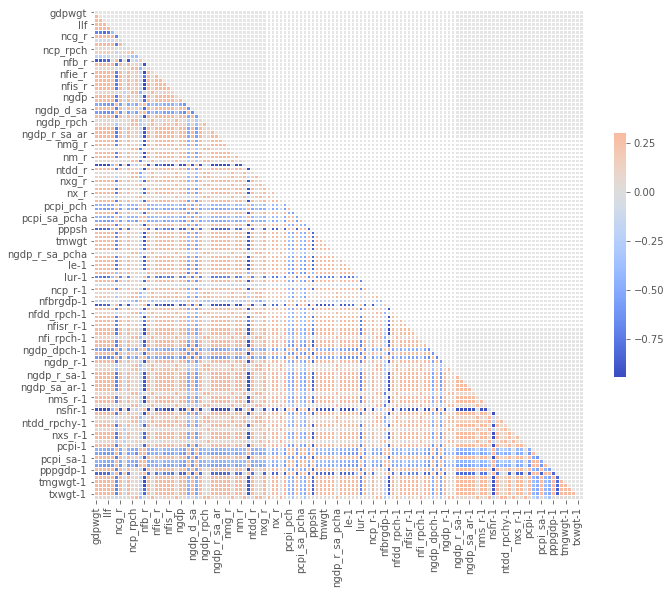

In [34]:
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(x_corr, dtype=np.bool))
sns.heatmap(x_corr, mask=mask, vmax=.3, center=0, cmap= 'coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# PCA

In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [36]:
samples = X_train.dropna()

In [37]:
scaler = StandardScaler()
X = scaler.fit_transform(samples)

In [38]:
pca = PCA(n_components=10)
principal_components = pca.fit_transform(X)

In [39]:
new_X = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2', 'PC3', 
                                                    'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
new_X.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-16.022613,13.999853,7.478686,-5.805154,-2.607761,-1.969852,-0.051979,-2.298054,-0.381877,0.106159
1,-16.126386,15.279785,0.485146,0.884501,2.376871,5.305971,3.262117,3.694067,-0.816311,-0.408316
2,-14.988642,5.924228,4.170611,6.727991,6.076587,2.512163,-3.377013,1.423326,1.133661,-0.927202
3,-14.263499,1.924094,8.737008,3.924721,2.588259,-2.401275,0.321785,-2.304023,1.650975,-1.593986
4,-13.778223,4.088768,6.735154,-0.313605,-1.376211,-2.980682,0.579974,-0.558330,-0.419576,-0.253565


<BarContainer object of 10 artists>

Text(0, 0.5, 'percentange of explained variance')

Text(0.5, 0, 'principal component')

Text(0.5, 1.0, 'variable importance')

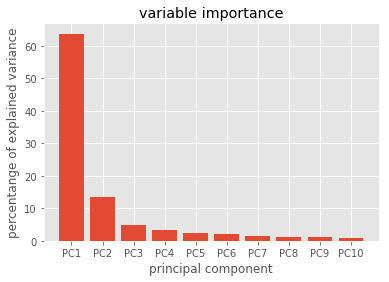

In [40]:
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('percentange of explained variance')
plt.xlabel('principal component')
plt.title('variable importance')
plt.show()

In [41]:
per_var

array([63.75, 13.4 ,  4.94,  3.42,  2.53,  1.98,  1.47,  1.27,  1.21,
        0.92])

In [42]:
per_var.sum()

94.89

## Transformed features corr

In [43]:
corr = pca.get_covariance()

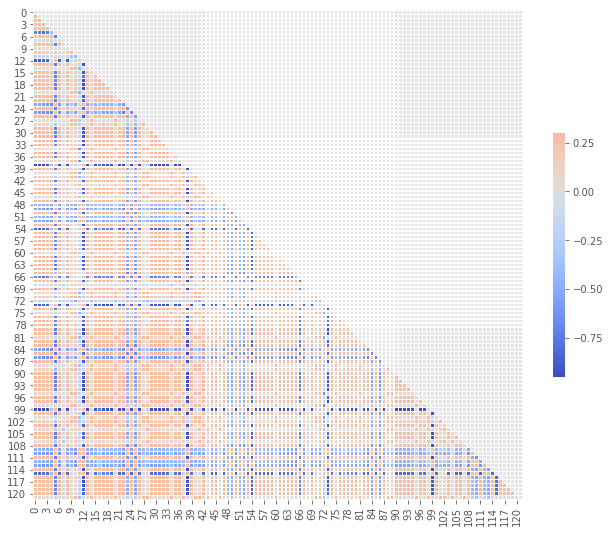

In [44]:
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask=mask, vmax=.3, center=0, cmap= 'coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## PC loadings (loading matrix)

In [49]:
pca.components_.shape

(10, 122)

In [50]:
pca.explained_variance_.shape

(10,)

In [45]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

In [46]:
df_loadings = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 
                                              'PC8', 'PC9', 'PC10'])
df_loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,0.996793,0.093959,0.015918,0.030289,0.032182,-0.026902,0.019631,-0.011801,-0.031427,0.017152
1,0.998372,0.095599,0.034204,0.029126,0.015973,-0.014158,0.008031,-0.004266,-0.011026,0.002414
2,0.993442,0.042941,-0.031357,-0.086917,0.040398,-0.002134,-0.016659,0.014919,0.073529,-0.029289
3,0.996660,0.049662,-0.057116,-0.044173,0.047726,-0.035448,0.002171,0.002990,0.030442,-0.007787
4,0.402120,-0.159092,-0.619807,-0.305840,0.169860,-0.281565,-0.038651,0.046242,0.271452,-0.109973
...,...,...,...,...,...,...,...,...,...,...
117,0.973120,0.171692,0.085867,0.095111,-0.019449,0.014871,0.003581,-0.023596,-0.059463,0.019195
118,0.975695,0.167116,0.080165,0.087624,-0.010680,0.011294,0.005289,-0.023423,-0.058946,0.019260
119,0.975085,0.119718,0.000204,0.090708,-0.013807,-0.082977,-0.007381,0.036049,0.077670,-0.050688
120,0.980942,0.112913,-0.000738,0.077150,0.000273,-0.078855,-0.003147,0.032570,0.067686,-0.044602


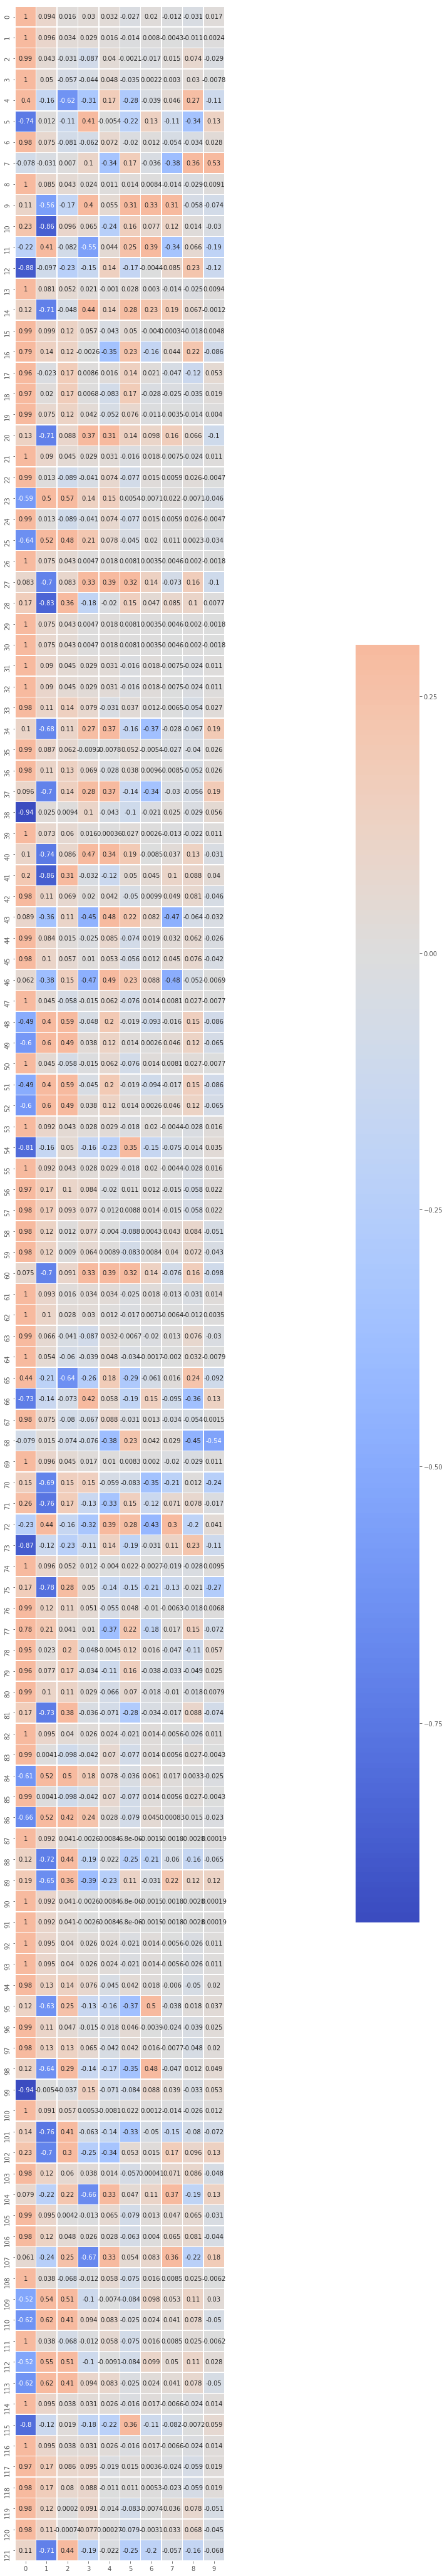

In [48]:
f, ax = plt.subplots(figsize=(75,75))
sns.heatmap(loadings, vmax=.3, center=0, cmap= 'coolwarm', annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})